In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler

opt_data = pd.read_csv('data/opt_data.csv')
drift = pd.read_csv('data/drift_data.csv')
excursion_data = pd.read_csv('data/excursion_data.csv')

drift_data = drift.copy()

X = drift_data.drop(columns=['outcome'])
y = drift_data['outcome']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=42)

# K-Fold cross-validator
kfold = KFold(n_splits=5, shuffle=True, random_state=42)


In [16]:
def tune_and_evaluate_full(model, param_grid, name):
    # Grid Search for Best Params
    search = GridSearchCV(model, param_grid, cv=kfold, scoring="neg_mean_squared_error", verbose=0)
    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    # Error Metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name} -> RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

    ## 1. Prediction Error Plot (Actual vs Predicted)
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, color='darkcyan', alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='black', linestyle="--", linewidth=1)
    plt.title(f"Actual vs Predicted - {name}")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.grid()
    plt.tight_layout()
    plt.show()
    
    
    ## 2. Residual KDE Plot
    residuals = y_test - y_pred
    plt.figure(figsize=(8, 6))
    sns.kdeplot(residuals, fill=True, color="steelblue")
    plt.title(f"Residual Distribution - {name}")
    plt.xlabel("Residuals")
    plt.ylabel("Density")
    plt.grid()
    plt.tight_layout()
    plt.show()
    
    ## 3. Lift Chart (Actual vs Predicted across Deciles)
    df_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    df_results['Decile'] = pd.qcut(df_results['Predicted'], 10, labels=False, duplicates='drop')
    lift_chart = df_results.groupby('Decile')[['Actual', 'Predicted']].mean()
    plt.figure(figsize=(8, 6))
    lift_chart.plot(kind='line', marker='o')
    plt.title(f"Lift Chart (Actual vs Predicted) - {name}")
    plt.xlabel("Predicted Deciles")
    plt.ylabel("Values")
    plt.grid()
    plt.tight_layout()
    plt.show()

    ## Feature Importance for Tree Models
    if hasattr(best_model, "feature_importances_"):
        importances = best_model.feature_importances_
        feature_df = pd.DataFrame({"Feature": X.columns, "Importance": importances})
        feature_df = feature_df.sort_values(by="Importance", ascending=False)
        
        plt.figure(figsize=(8, 6))
        sns.barplot(x="Importance", y="Feature", data=feature_df, palette="viridis")
        plt.title(f"Feature Importance for {name}")
        plt.tight_layout()
        plt.show()

    return best_model, rmse, mae


In [17]:
def compare_models(mae_results, rmse_results):
    metrics_df = pd.DataFrame({"Model": mae_results.keys(), "MAE": mae_results.values(), "RMSE": rmse_results.values()})
    metrics_df = metrics_df.melt(id_vars="Model", var_name="Metric", value_name="Score")
    
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=metrics_df, x="Model", y="Score", hue="Metric", marker="o", palette="coolwarm")
    plt.title("Model Performance Comparison")
    plt.ylabel("Error Score")
    plt.xlabel("Models")
    plt.grid()
    plt.tight_layout()
    plt.show()


--- Tuning and Evaluating Random Forest ---
Random Forest -> RMSE: 0.1562, MAE: 0.1228, R²: 0.9136


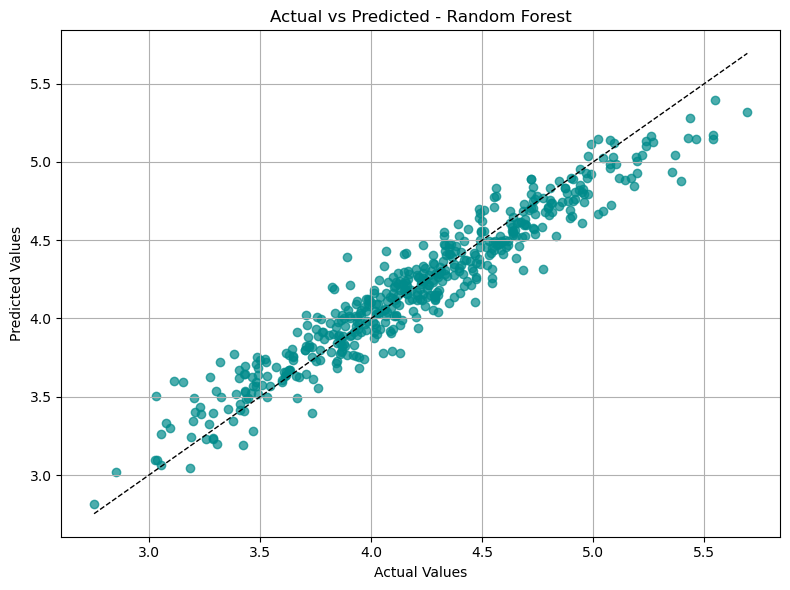

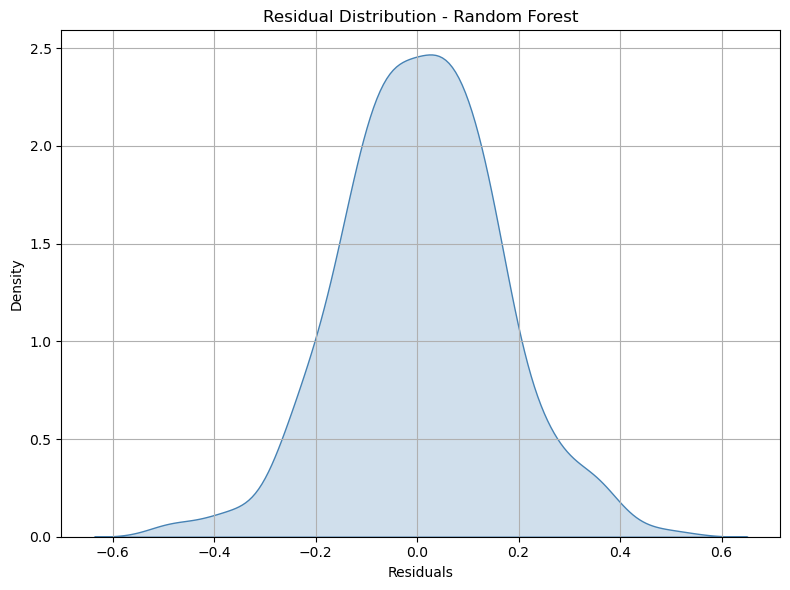

<Figure size 800x600 with 0 Axes>

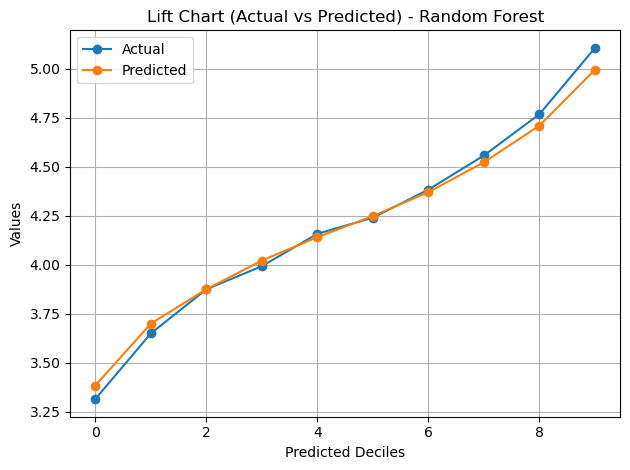

C:\Users\hrith\AppData\Local\Temp\ipykernel_27728\3807112924.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_df, palette="viridis")


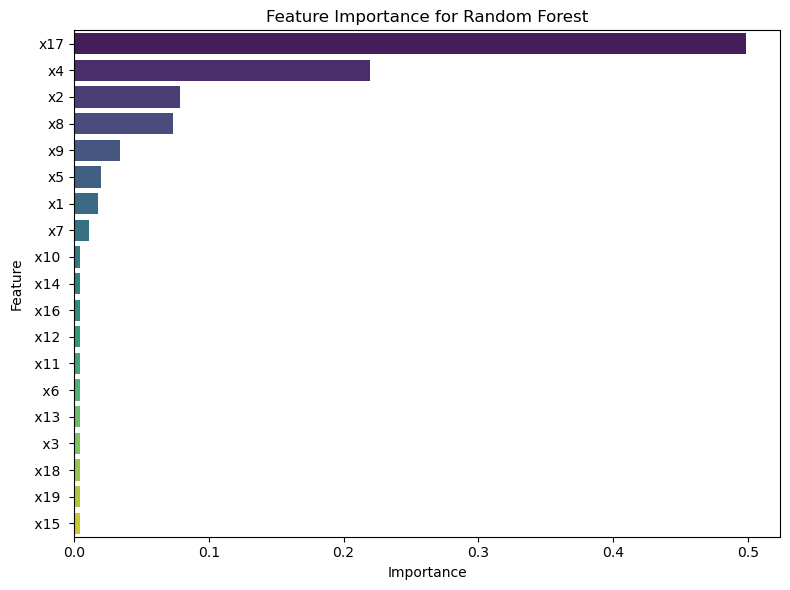

--- Tuning and Evaluating XGBoost ---
XGBoost -> RMSE: 0.0628, MAE: 0.0475, R²: 0.9860


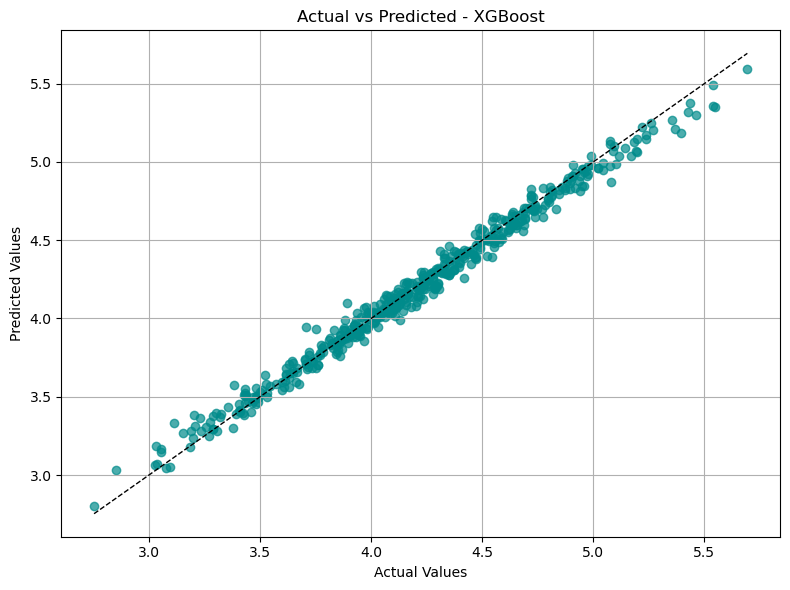

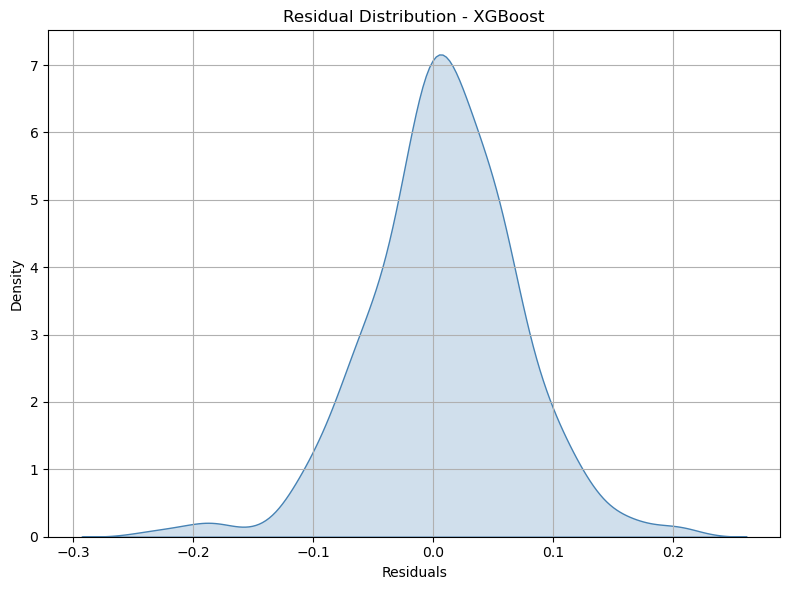

<Figure size 800x600 with 0 Axes>

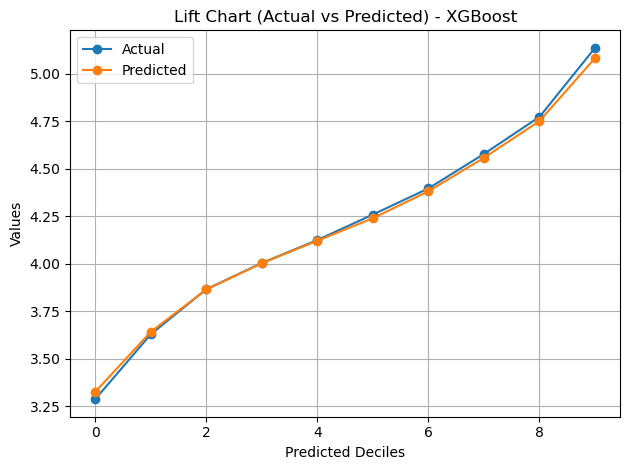

C:\Users\hrith\AppData\Local\Temp\ipykernel_27728\3807112924.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_df, palette="viridis")


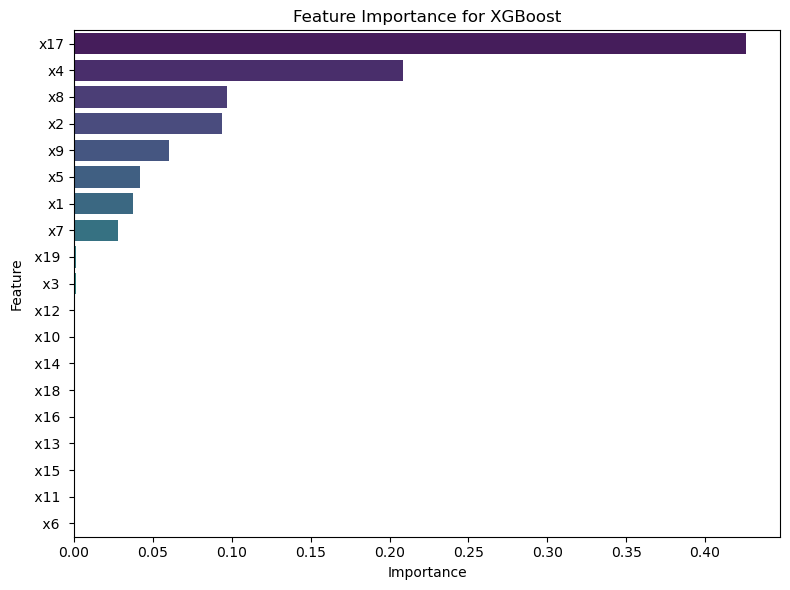

--- Tuning and Evaluating Ridge Regression ---
Ridge Regression -> RMSE: 0.0253, MAE: 0.0169, R²: 0.9977


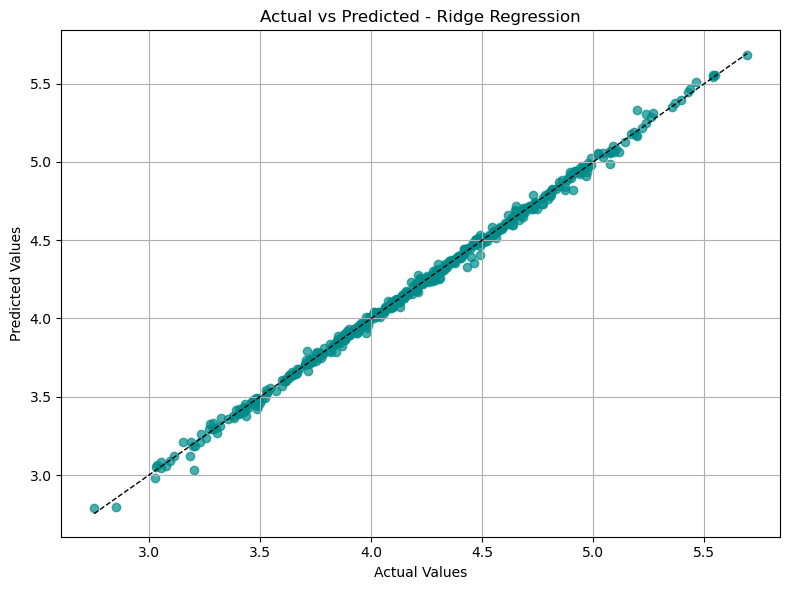

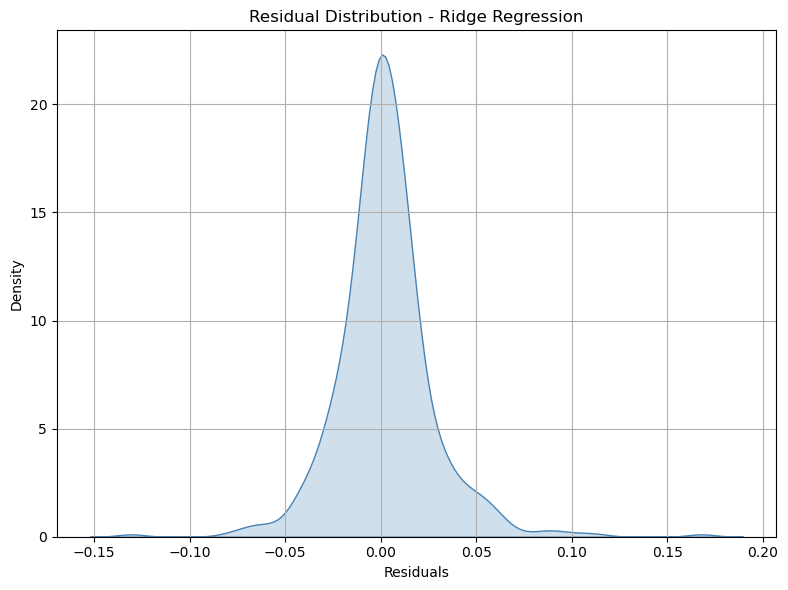

<Figure size 800x600 with 0 Axes>

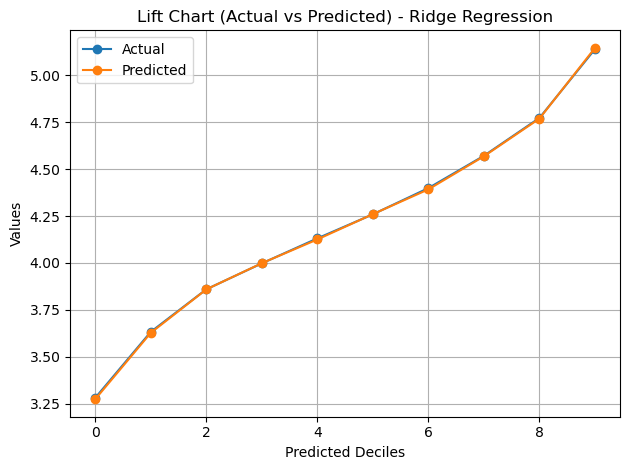

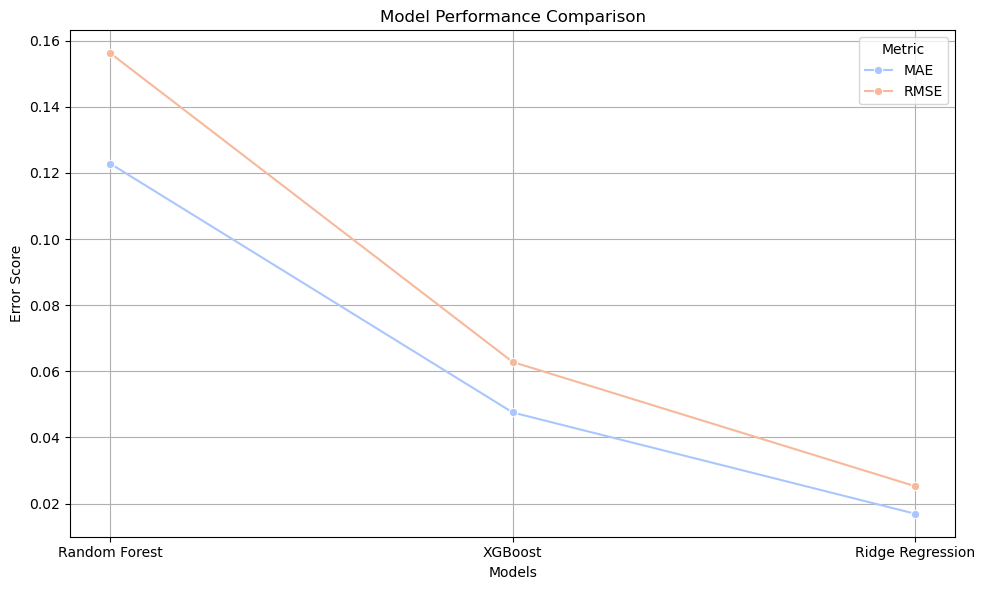

In [18]:
models = {
    "Random Forest": (RandomForestRegressor(), {"n_estimators": [50, 100, 200], "max_depth": [None, 10, 20], 'min_samples_split': [2, 5, 10]}),
    "XGBoost": (XGBRegressor(), {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.05, 0.1], 'max_depth': [3, 5, 7]}),
    "Ridge Regression": (Ridge(), {"alpha": [0.01, 0.1, 1, 10]})
}

mae_results = {}
rmse_results = {}
best_models = {}

# Train and Evaluate Each Model
for name, (model, params) in models.items():
    print(f"--- Tuning and Evaluating {name} ---")
    best_model, rmse, mae = tune_and_evaluate_full(model, params, name)
    mae_results[name] = mae
    rmse_results[name] = rmse
    best_models[name] = best_model

# Compare Model Performances
compare_models(mae_results, rmse_results)


In [20]:
best_models

{'Random Forest': RandomForestRegressor(max_depth=20, n_estimators=200),
 'XGBoost': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...),
 'Ridge Regression': Ridge(alpha=0.01)}